Example 3: Clustering RdRps
=============================

In [2]:
import numpy as np
import itertools as it
import multiprocess
import matplotlib.pyplot as plt
import time
import os
from umap.umap_ import UMAP

from GWProt.GW_protein import *
from GWProt.GW_protein_pI import *

/home/elijah/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/elijah/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/elijah/.local/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDeprecationWarning: Th


Riboviruses are a realm of viruses which include many human pathogens. They all have an essential RNA-dependent RNA-polymerase (RdRp) which is key to their replication machinery, has a high mutation rate, and often very low sequence homology; thus structural comparison can be key to identification and classification. In our benchmarking of GWProt, we used a dataset of 4,615 computationally determined (AlphaFold3) structures of viral RNA-dependent RNA polymerases (RdRp) as well as 512 non-RdRp “decoy” proteins, which were selected as non-viral homologs. For our testing we used taxonomical annotations retrieved from Entrez, with 5 phyla of riboviruses.

Here we display a UMAP clustering of the different phyla and decoys:


![Example_Data/Images/GW_Phylum_Clustering.PNG](Example_Data/Images/GW_Phylum_Clustering.PNG)

In this tutorial we use a subset consisting of 50 randomly chosen RdRps from the phyla Lenaviricota and Duplornaviricota.
We will run different variants of Gromov-Wasserstein which can be computed with GWProt to show their differences in clustering accuracy and runtime. All runtime is based on 16 parallel processes on a desktop computer. 

In [3]:
duplos = [os.path.join("Example_Data/RdRp Proteins/Duplo_RdRps", file) for file in os.listdir("Example_Data/RdRp Proteins/Duplo_RdRps")]
lenas = [os.path.join("Example_Data/RdRp Proteins/Lena_RdRps", file) for file in os.listdir("Example_Data/RdRp Proteins/Lena_RdRps")]

pisus = [os.path.join("Example_Data/RdRp Proteins/Pisu_RdRps", file) for file in os.listdir("Example_Data/RdRp Proteins/Pisu_RdRps")]
negas = [os.path.join("Example_Data/RdRp Proteins/Nega_RdRps", file) for file in os.listdir("Example_Data/RdRp Proteins/Nega_RdRps")]


We define a helper method to compute pairwise all-vs-all GW distances, then display 
to compute the [silhoutte score](https://en.wikipedia.org/wiki/Silhouette_(clustering)#:~:text=The%20silhouette%20score%20is%20specialized,distance%20or%20the%20Manhattan%20distance.) and [Davies-Bouldin score](https://en.wikipedia.org/wiki/Davies–Bouldin_index), two basic measures of clustering to evaluate the accuracy of different methods in GWProt. A higher silhoutte score and lower Davies-Bouldin score mean better clustering.

In [4]:
from sklearn.metrics import silhouette_score # higher is better
from sklearn.metrics import davies_bouldin_score #lower is better

def display(dist_mat):
    N = dist_mat.shape[0]


    print(f"Silhouette Score: {silhouette_score(X = dist_mat, labels = [0 if i <(N//2) else 1 for i in range(N)], metric='precomputed')}")
    print(f"Davies-Bouldin Score: {davies_bouldin_score(dist_mat, labels = [0 if i <(N//2) else 1 for i in range(N)])}")
    
    reducer = UMAP(metric = 'precomputed', random_state=1)
    embedding = reducer.fit_transform(dist_mat)
    plt.figure(figsize=(4, 4))
    plt.scatter(embedding[:(N//2), 0], embedding[:(N//2), 1], c= ['red']*(N//2) , s=5)
    plt.scatter(embedding[(N//2):, 0], embedding[(N//2):, 1], c= ['blue']*(N//2) , s=5)
    plt.legend(["Dupl." , "Lena."])
    plt.show()
    

In [5]:
def compute_in_parallel(proteins, comparison_method, returning = False, **kwargs):
    N = len(proteins)
    dist_mat = np.zeros((N,N))
    start_time = time.time()

    with multiprocess.Pool() as pool:
        for r in  pool.imap(lambda pair: (pair[0], pair[1], comparison_method(proteins[pair[0]], proteins[pair[1]], **kwargs)), it.combinations(range(N),2)):
            i,j,d = r
            dist_mat[i,j] = d
            dist_mat[j,i] = d
            
    print(f'run time = {time.time() - start_time}')
    display(dist_mat)
    if returning:
        return dist_mat
    

The main class in GWProt is `GW_protein`, whose objects contain the relevant data for a protein including the coordinates of each alpha-Carbon, the sequence, and the intra-protein distance matrix, an array containing all pairwise distances between alpha-Carbons. We can initialize objects in this class from PDB (protein databank) files.

In [11]:
base_prots = [GW_protein.make_protein_from_pdb(file) for file in duplos + lenas]
base_prots = [GW_protein.make_protein_from_pdb(file) for file in lenas + pisus]

For faster computations, we can downsample to an evenly spaced subset of the residues:

In [15]:
downsamped_100_prots = [p.downsample_n(n=100) for p in base_prots]

We can also rescale the intra-protein distance matrices, where computing GW distances gives greater weight to local distances.

In [16]:
scaled_prots = [p.scale_ipdm(inplace = False) for p in base_prots]

We can also combine both variants and confirm that the order does not matter:

In [17]:
downsampled_then_scaled_prots = [p.scale_ipdm(inplace = False) for p in downsamped_100_prots]
scaled_then_downsampled_prots = [p.downsample_n(n=100) for p in scaled_prots]
assert downsampled_then_scaled_prots == scaled_then_downsampled_prots

In [10]:
GW_dist_mat = compute_in_parallel(proteins=base_prots, returning= True, comparison_method= GW_protein.run_GW)

Process ForkPoolWorker-4:
Process ForkPoolWorker-11:
Process ForkPoolWorker-1:
Process ForkPoolWorker-13:
Process ForkPoolWorker-15:
Process ForkPoolWorker-8:
Process ForkPoolWorker-6:
Process ForkPoolWorker-3:
Process ForkPoolWorker-2:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/elijah/.local/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/home/elijah/.local/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/home/elijah/.local/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/home/elijah/.local/lib/python3.10/site-packages/multiprocess/process.py", line 314, in _bootstrap
    self.run()
  File "/home/elijah/.local/li

run time = 80.63600015640259
Silhouette Score: 0.12225568220905543
Davies-Bouldin Score: 2.089772502538112


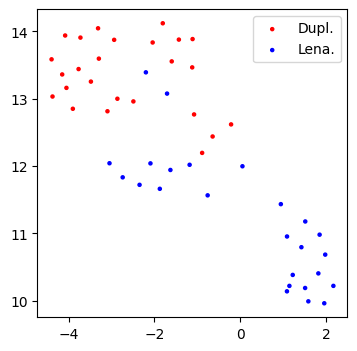

In [18]:
compute_in_parallel(proteins=downsamped_100_prots, comparison_method= GW_protein.run_GW)

run time = 81.29926753044128
Silhouette Score: 0.12478009274520434
Davies-Bouldin Score: 1.8948958440721686


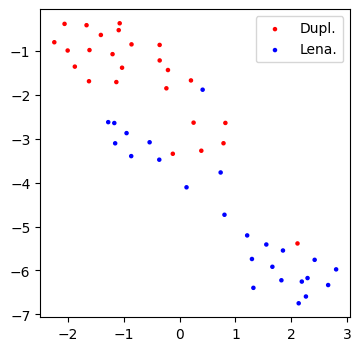

In [19]:
compute_in_parallel(proteins=downsampled_then_scaled_prots, comparison_method= GW_protein.run_GW)

Next we confirm that this agrees with running GW directly from CAJAL cells

In [ ]:
cajal_cells = [p.make_cajal_cell() for p in base_prots]
GW_cajal_dist_mat = compute_in_parallel(cajal_cells, GW_protein.run_GW_from_cajal, returning =True)
assert np.isclose(GW_cajal_dist_mat, GW_dist_mat).all()


In [ ]:
import GWProt.FGW_matrices

In [ ]:
from GWProt.FGW_matrices import *

compute_in_parallel(proteins=base_prots, comparison_method=GW_protein.run_FGW_dict, alpha = 0.05,d = get_BLOSUM_dict(n = 62))

We also demonstrate using user-inputted data:

In [ ]:
eccentricity_lists = [p.get_eccentricity() for p in base_prots]
FGW_eccentricity_dist_mat = np.zeros((50,50))

start_time = time.time()
with multiprocess.Pool() as pool:
    results = pool.imap(lambda pair: (pair[0], pair[1], GW_protein.run_FGW_data_lists(base_prots[pair[0]], 
                                                                                 base_prots[pair[1]], 
                                                                                 data1 = eccentricity_lists[pair[0]],
                                                                                data2 = eccentricity_lists[pair[1]],
                                                                                      alpha = 0.05)), it.combinations(range(50),2))
    for r in results:
        i,j,d = r
        FGW_eccentricity_dist_mat[i,j] = d
        FGW_eccentricity_dist_mat[j,i] = d
run_time = time.time() - start_time

In [ ]:
display(FGW_eccentricity_dist_mat)


Now we show the functionality of ``GW_protein_pI``

In [9]:
base_prots_pI = [GW_protein_pI.make_protein_from_pdb(file) for file in duplos + lenas]

We check that after casting to ``GW_protein`` s they agree with the earlier ones.

In [10]:
assert base_prots == [p.GW_protein() for p in base_prots_pI]

In [15]:
compute_in_parallel(proteins=base_prots_pI, comparison_method= GW_protein_pI.run_FGW, alpha = 0.05)

run time = 2211.666257381439
Silhouette Score: 0.0614530726915074
Davies-Bouldin Score: 3.2662274566615586


TypeError: slice indices must be integers or None or have an __index__ method

<Figure size 400x400 with 0 Axes>

In [11]:
convolved_prots = [p.convolve_pIs() for p in base_prots_pI]



In [ ]:
compute_in_parallel(proteins=convolved_prots, comparison_method= GW_protein_pI.run_FGW_seq_aln, alpha = 0.05)

In [ ]:
compute_in_parallel(proteins=FGW_downsampled, comparison_method= GW_protein_pI.run_FGW, alpha = 0.05)

In [9]:
%debug

> /tmp/ipykernel_21296/2783908162.py(1)<module>()
----> 1 type(p)



ipdb>  p


*** SyntaxError: invalid syntax
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [12]:
FGW_downsampled = [p.downsample_n(100) for p in convolved_prots]